# HelloWo.. [CIFAR10](https://keras.io/datasets/)!

In this notebook, we will explore convolutional neural networks.

First, we load numpy and matplotlib as well as the keras layers we need.

In [1]:
# numpy and plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# keras
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Softmax
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import metrics

/sw/apps/python3/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/sw/apps/python3/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


** Load CIFAR10 dataset **

We load the CIFAR10 dataset provided by keras, it contains 32x32-pixel images from ten classes.

In [2]:
from keras.datasets import cifar10
from keras import backend as K

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# maximum value normalization
x_train /= 255
x_test /= 255

num_classes = 10
batch_size = 128


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In the next cell, we set reshape the dataset to have the color channels in the place the backend require. Tensorflow requires "channels_last".

We also convert the labels to one-hot-encoded labels.

In [3]:
# Convert class vectors to binary class matrices.
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

img_rows, img_cols, channels = x_train.shape[1:]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(K.image_data_format())
print(input_shape)
print(y_train[0])

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)
channels_last
(32, 32, 3)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [4]:
def predictCategorical(idx, model, data, preproc= None, cols=5):
    try:
        idx = list(idx)
    except:
        idx = [idx]
        
    data = data[idx]
        
    p = model.predict(data if preproc is None else preproc(data))
    
    ncats = 0
    ndogs = 0
    nother = 0
    
    i=0
    labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    while i < p.shape[0]:
        fig, axs = plt.subplots(1,cols,figsize=(5*cols,5))
        fig.figsize=(20,10)
        for ax in axs:
            ax.imshow(data[i])
            label = np.argsort(p[i])[-1]
            ax.text(.5,0, labels[label]+", score "+str(p[i][label]),
                    horizontalalignment='center', verticalalignment='bottom', transform=ax.axes.transAxes,
                    backgroundcolor="white", size="large")
            i += 1
            if i >= p.shape[0]:
                break
            
        plt.show()

## Baseline: Multi-Layer Perceptron (MLP)

To get a baseline, we try a multi-layer perceptron: A model with a few hidden dense layers. If there are enough of those (>~3), the model can be considered deep.

In [5]:
def makeMLP(hidden = [512,512,256], activation = 'relu', input_shape=input_shape, num_classes=num_classes):
    model = Sequential()
    
    # converts the images (32x32x3) into vectors
    model.add(Flatten(input_shape=input_shape))
    model.add(BatchNormalization())
    for a in hidden:
        model.add(Dense(a, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [6]:
model = makeMLP()
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 1,982,218
Trainable params: 1,976,074
Non-trainable params: 6,144
______________________________________________________________

Note, that this small MLP with three hidden layers of sizes 512, 512 and 256, already has about 2 million trainable parameters. The size of 512 activations is also not unreasonably large, as this already leads to a dimensional reduction of the input by a factor of 6.

In [7]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=20,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 5s 108us/step - loss: 1.7315 - acc: 0.3929 - val_loss: 1.5469 - val_acc: 0.4495
Epoch 2/20
50000/50000 [==============================] - 3s 54us/step - loss: 1.4731 - acc: 0.4795 - val_loss: 1.4705 - val_acc: 0.4854
Epoch 3/20
50000/50000 [==============================] - 3s 54us/step - loss: 1.3462 - acc: 0.5233 - val_loss: 1.4499 - val_acc: 0.4978
Epoch 4/20
50000/50000 [==============================] - 3s 54us/step - loss: 1.2343 - acc: 0.5642 - val_loss: 1.3614 - val_acc: 0.5223
Epoch 5/20
50000/50000 [==============================] - 3s 54us/step - loss: 1.1394 - acc: 0.5960 - val_loss: 1.3831 - val_acc: 0.5260
Epoch 6/20
50000/50000 [==============================] - 3s 54us/step - loss: 1.0576 - acc: 0.6232 - val_loss: 1.4500 - val_acc: 0.5194
Epoch 7/20
50000/50000 [==============================] - 3s 54us/step - loss: 0.9696 - acc: 0.6550 - val_loss: 1.4196 - val_ac

We can note down, that the validation accuray maxes out at about 53%. This is not nothing, as with ten classed, pure guessing would give an accuracy of 10%.

It also starts overfitting quite quickly. This could be mitigated by using data augmentation and more regularization to an extent, which could also inprove the generalization somewhat. But we want to focus on the comparison with convnets here and thus will keep the other aspects simple. 

# Convolutional Neural Network

Let us no go to a very simple CNN. We compared to the previous MLP, we only replace the two larger hidden layers near the bottom by downsampling conv-layers. 



In [20]:
def makeCNN1(filters = (32, 64), dense = (256,), kernel_size=(3,3), activation='relu'
            , input_shape=input_shape, num_classes=num_classes, normAfterConv=False):
    model = Sequential()
    
    # using input layer to set input size explicitly, before we loop over layers
    model.add(BatchNormalization(input_shape=input_shape))
    
    for a in filters:
        
        model.add(Conv2D(a, kernel_size=kernel_size, activation=activation, strides=(2,2)))
        if normAfterConv:
            model.add(BatchNormalization())
    
    model.add(Flatten())
    
    for a in dense:
        model.add(Dense(a, activation=activation))
    
    model.add(Dense(num_classes, activation='softmax'))
       
    return model

In [21]:
model = makeCNN1()
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_8 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_7 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               803072    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                2570      
Total params: 825,046
Trainable params: 825,040
Non-trainable params: 6
_________________________________________________________________


The concept of having conv layers 'looking' at the data and dense layers at the bottom interpreting the features found by the convolutional filters, has been used by early ImageNet-winning deep conv-nets.

Note, that this model only has ~825k trainable parameters, of which more than 800k are in the bottom dense layers.

In [22]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s 86us/step - loss: 1.5134 - acc: 0.4652 - val_loss: 1.2599 - val_acc: 0.5505
Epoch 2/10
50000/50000 [==============================] - 3s 52us/step - loss: 1.1003 - acc: 0.6133 - val_loss: 1.0859 - val_acc: 0.6171
Epoch 3/10
50000/50000 [==============================] - 3s 52us/step - loss: 0.8870 - acc: 0.6899 - val_loss: 1.0209 - val_acc: 0.6517
Epoch 4/10
50000/50000 [==============================] - 3s 52us/step - loss: 0.7084 - acc: 0.7554 - val_loss: 0.9989 - val_acc: 0.6638
Epoch 5/10
50000/50000 [==============================] - 3s 52us/step - loss: 0.5363 - acc: 0.8162 - val_loss: 1.0885 - val_acc: 0.6631
Epoch 6/10
50000/50000 [==============================] - 3s 53us/step - loss: 0.3754 - acc: 0.8745 - val_loss: 1.1387 - val_acc: 0.6695
Epoch 7/10
50000/50000 [==============================] - 3s 53us/step - loss: 0.2337 - acc: 0.9260 - val_loss: 1.3288 - val_acc

This model already reaches a validation accuracy of ~65%, about 10% more than our MLP. It seems to be even more prone to overfitting, however. This could be improved by adding more regularization.

### Pure Convnet

Let us try an (almost) pure convnet next. Basically, we eliminate the hidden dense layers completely and only retain the dens output layer, which uses the feature map generated by the conv layers and produces the prediction. We add more conv layers to improve the models abstraction ability and to produce a smaller featuremap at the bottom, which controls the input size of the final dense layer.

In [25]:
model = makeCNN1((32,64,96,96),[], normAfterConv=True)
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_14 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 3, 3, 96)          55392     
_________________________________________________________________
batch_normalization_17 (Batc (None, 3, 3, 96)          384       
__________

In [26]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 5s 102us/step - loss: 1.4274 - acc: 0.4905 - val_loss: 1.2927 - val_acc: 0.5463
Epoch 2/10
50000/50000 [==============================] - 4s 78us/step - loss: 1.0553 - acc: 0.6246 - val_loss: 1.0430 - val_acc: 0.6315
Epoch 3/10
50000/50000 [==============================] - 4s 77us/step - loss: 0.8673 - acc: 0.6939 - val_loss: 0.9727 - val_acc: 0.6598
Epoch 4/10
50000/50000 [==============================] - 4s 78us/step - loss: 0.7270 - acc: 0.7449 - val_loss: 0.9791 - val_acc: 0.6694
Epoch 5/10
50000/50000 [==============================] - 4s 78us/step - loss: 0.6147 - acc: 0.7871 - val_loss: 0.9721 - val_acc: 0.6716
Epoch 6/10
50000/50000 [==============================] - 4s 78us/step - loss: 0.5154 - acc: 0.8220 - val_loss: 0.9672 - val_acc: 0.6825
Epoch 7/10
50000/50000 [==============================] - 4s 79us/step - loss: 0.4296 - acc: 0.8509 - val_loss: 1.0156 - val_ac

This mode is only marginally better, but note, that now we only need ~169k parameters to get the same result.

### Small Darknet

The previous CNNs took some inspiration from an architecture called darknet, which is used in the YOLO approach to object detection [https://pjreddie.com/darknet/yolo/] .

The inspired part is increasing the number of filters after downsamling, but there is more to the to that architecture. So let us try this correctly, but smaller.

In [27]:
def makeSmallDarknet(nunits=3, nfilters0=16, kernel_size=(3,3), activation='relu'
                     , input_shape=input_shape, num_classes=num_classes):
    model = Sequential()
    
    model.add(Conv2D(nfilters0, kernel_size=kernel_size, activation=activation
                     , input_shape=input_shape, padding="same"))
    
    for a in range(1,nunits+1):
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        nfilters = int(nfilters0*(2**a))
        for s in range(a//2):
            model.add(Conv2D(nfilters, kernel_size=kernel_size, activation=activation, padding="same"))
            model.add(Conv2D(nfilters//2, kernel_size=(1,1), activation=activation))
        model.add(Conv2D(nfilters, kernel_size=kernel_size, activation=activation, padding="same"))
        
    model.add(Conv2D(num_classes, kernel_size=(1,1), activation=activation))
    model.add(GlobalAveragePooling2D())
    model.add(Softmax())
    
    return model

In [28]:
model = makeSmallDarknet()
model.summary()

opt = keras.optimizers.adam(lr=0.0001, decay=1e-6)

model.compile(loss=keras.losses.categorical_crossentropy,
              #optimizer=opt,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 8, 32)          128       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 64)          18496     
__________

In [29]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 5s 107us/step - loss: 1.4497 - acc: 0.4621 - val_loss: 1.2739 - val_acc: 0.5483
Epoch 2/10
50000/50000 [==============================] - 4s 83us/step - loss: 1.0255 - acc: 0.6305 - val_loss: 1.1677 - val_acc: 0.5840
Epoch 3/10
50000/50000 [==============================] - 4s 82us/step - loss: 0.8544 - acc: 0.6946 - val_loss: 1.5103 - val_acc: 0.5046
Epoch 4/10
50000/50000 [==============================] - 4s 83us/step - loss: 0.7335 - acc: 0.7399 - val_loss: 0.8633 - val_acc: 0.7027
Epoch 5/10
50000/50000 [==============================] - 4s 83us/step - loss: 0.6473 - acc: 0.7699 - val_loss: 1.0108 - val_acc: 0.6689
Epoch 6/10
50000/50000 [==============================] - 4s 83us/step - loss: 0.5782 - acc: 0.7972 - val_loss: 0.9051 - val_acc: 0.6922
Epoch 7/10
50000/50000 [==============================] - 4s 83us/step - loss: 0.5133 - acc: 0.8192 - val_loss: 1.0470 - val_ac

This model can us ~70% in validation accuracy, but since we are not augmenting the data here it also starts to overfit quickly.

Using data augmentation, it can reach >80%, but this takes a while.

In [30]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_generator = train_datagen.flow(x_train, y_train,
    batch_size=batch_size)

In [31]:
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=50000 // batch_size,
        epochs=50,
        validation_data=(x_test, y_test))

Epoch 1/50
390/390 [==============================] - 16s 41ms/step - loss: 0.9089 - acc: 0.6854 - val_loss: 0.9605 - val_acc: 0.6862
Epoch 2/50
390/390 [==============================] - 17s 44ms/step - loss: 0.8324 - acc: 0.7100 - val_loss: 0.8196 - val_acc: 0.7232
Epoch 3/50
390/390 [==============================] - 16s 41ms/step - loss: 0.7978 - acc: 0.7232 - val_loss: 0.8193 - val_acc: 0.7177
Epoch 4/50
390/390 [==============================] - 16s 41ms/step - loss: 0.7694 - acc: 0.7324 - val_loss: 1.0286 - val_acc: 0.6748
Epoch 5/50
390/390 [==============================] - 16s 42ms/step - loss: 0.7490 - acc: 0.7375 - val_loss: 0.9197 - val_acc: 0.7084
Epoch 6/50
390/390 [==============================] - 16s 41ms/step - loss: 0.7293 - acc: 0.7456 - val_loss: 0.7796 - val_acc: 0.7339
Epoch 7/50
390/390 [==============================] - 16s 41ms/step - loss: 0.7100 - acc: 0.7515 - val_loss: 0.7868 - val_acc: 0.7269
Epoch 8/50
390/390 [==============================] - 16s 41ms

In [32]:
model.save_weights("darknet.h5")

### Getting and displaying the feature map

In [33]:
def makeSmallDarknetFkt(nunits=3, nfilters0=16, kernel_size=(3,3), activation='relu'
                     , input_shape=input_shape, num_classes=num_classes):
    model = Sequential()
    
    model.add(Conv2D(nfilters0, kernel_size=kernel_size, activation=activation
                     , input_shape=input_shape, padding="same"))
    
    for a in range(1,nunits+1):
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        nfilters = int(nfilters0*(2**a))
        for s in range(a//2):
            model.add(Conv2D(nfilters, kernel_size=kernel_size, activation=activation, padding="same"))
            model.add(Conv2D(nfilters//2, kernel_size=(1,1), activation=activation))
        model.add(Conv2D(nfilters, kernel_size=kernel_size, activation=activation, padding="same"))
    
    model.add(Conv2D(num_classes, kernel_size=(1,1), activation=activation))
    modelTop = Sequential()
    modelTop.add(GlobalAveragePooling2D(input_shape=model.output_shape[1:]))
    modelTop.add(Softmax())
    
    modelFull = Model(inputs=model.input, 
              outputs=modelTop(model.output))
    
    return modelFull, model

In [34]:
modelF, modelM = makeSmallDarknetFkt()
modelF.summary()

opt = keras.optimizers.adam(lr=0.01, decay=1e-6)

modelF.compile(loss=keras.losses.categorical_crossentropy,
              #optimizer=opt,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31_input (InputLayer) (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 8, 8, 32)          128       
__________

In [35]:
hist = modelF.fit_generator(
        train_generator,
        steps_per_epoch=50000 // batch_size,
        epochs=10,
        validation_data=(x_test, y_test))

Epoch 1/10
390/390 [==============================] - 18s 45ms/step - loss: 1.6571 - acc: 0.3923 - val_loss: 1.4625 - val_acc: 0.4821
Epoch 2/10
390/390 [==============================] - 17s 44ms/step - loss: 1.2855 - acc: 0.5393 - val_loss: 1.2304 - val_acc: 0.5613
Epoch 3/10
390/390 [==============================] - 17s 43ms/step - loss: 1.1379 - acc: 0.5950 - val_loss: 1.1523 - val_acc: 0.6062
Epoch 4/10
390/390 [==============================] - 17s 42ms/step - loss: 1.0319 - acc: 0.6305 - val_loss: 1.0312 - val_acc: 0.6388
Epoch 5/10
390/390 [==============================] - 17s 43ms/step - loss: 0.9599 - acc: 0.6595 - val_loss: 1.0685 - val_acc: 0.6383
Epoch 6/10
390/390 [==============================] - 16s 42ms/step - loss: 0.9078 - acc: 0.6802 - val_loss: 0.9775 - val_acc: 0.6661
Epoch 7/10
390/390 [==============================] - 17s 43ms/step - loss: 0.8642 - acc: 0.6951 - val_loss: 0.9886 - val_acc: 0.6657
Epoch 8/10
390/390 [==============================] - 17s 43ms

In [36]:
modelF.load_weights("darknet.h5")

In [37]:
def showMaps(idx, model, data, preproc= None, cols=5):
    try:
        idx = list(idx)
    except:
        idx = [idx]
        
    data = data[idx]
        
    p = model[0].predict(data if preproc is None else preproc(data))
    m = model[1].predict(data if preproc is None else preproc(data))
    m = np.argmax(m, axis=3)
    print(m.shape)
    
    ncats = 0
    ndogs = 0
    nother = 0
    
    i=0
    labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    while i < p.shape[0]:
        fig, axs = plt.subplots(2,cols,figsize=(5*cols,5))
        fig.figsize=(20,10)
        for ax, axM in zip(axs[0], axs[1]):
            ax.imshow(data[i])
            axM.imshow(m[i],vmin=0, vmax=len(labels)-1, interpolation="none")
            label = np.argsort(p[i])[-1]
            ax.text(.5,0, labels[label]+", score "+str(p[i][label]),
                    horizontalalignment='center', verticalalignment='bottom', transform=ax.axes.transAxes,
                    backgroundcolor="white", size="large")
            i += 1
            if i >= p.shape[0]:
                break
            
        plt.show()

(20, 4, 4)


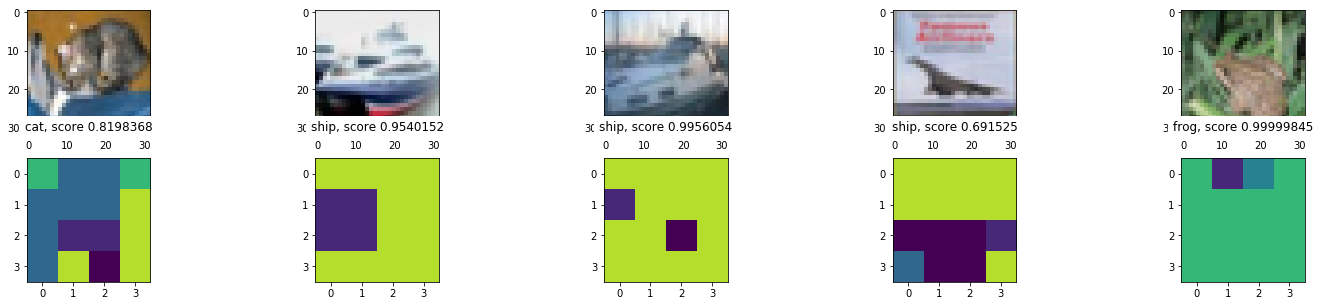

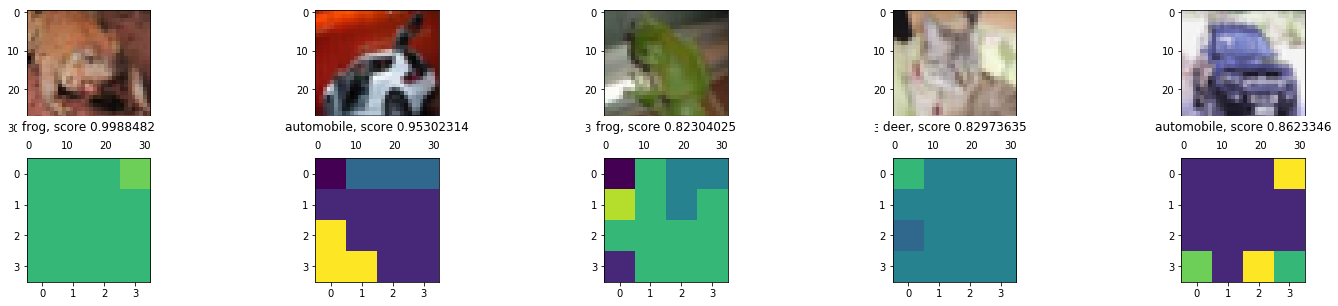

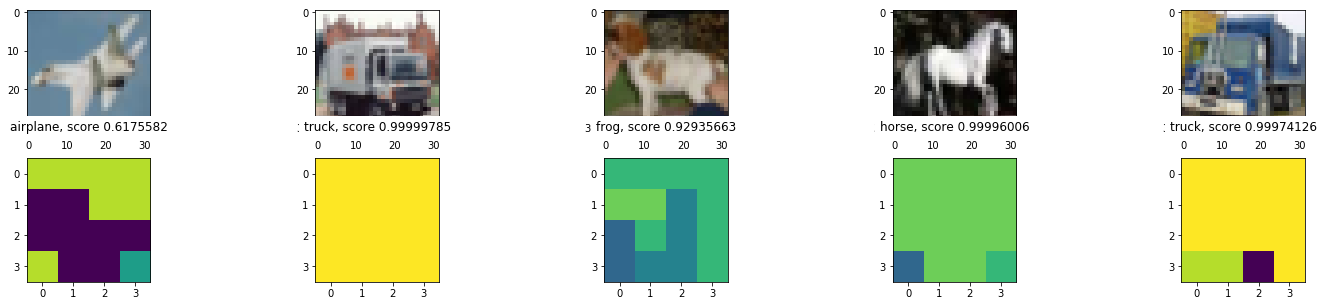

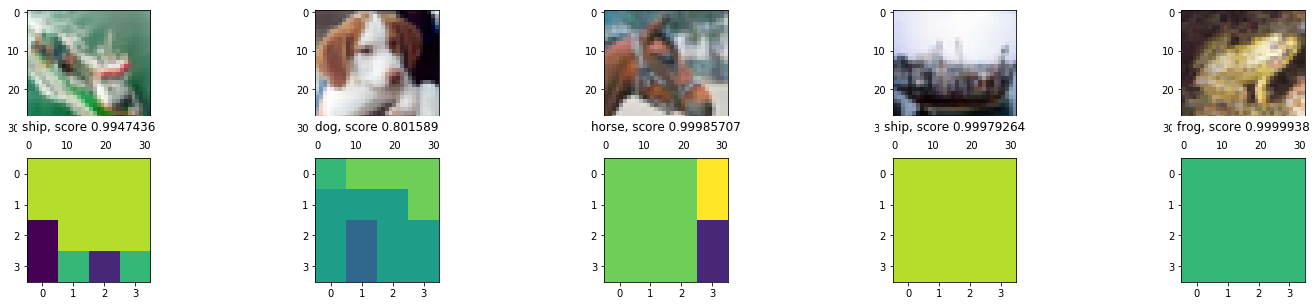

In [38]:
showMaps(range(20), (modelF,modelM), x_test)